# Phân tích T-Test cho dữ liệu cà phê Việt Nam

Trong bài này, em sẽ thực hiện kiểm định T-Test để so sánh:
- Giá cà phê giữa các tỉnh
- Sản lượng giữa các tỉnh
- Diện tích trồng giữa các tỉnh
- Thời tiết (nhiệt độ, lượng mưa) giữa các tỉnh

In [50]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, shapiro
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')

print("Đã import thành công!")

Đã import thành công!


In [51]:
# Kết nối database
load_dotenv()

host = os.getenv('HOST')
user = os.getenv('USER')
password = os.getenv('PASSWORD')
port = os.getenv('PORT', '19034')
database = os.getenv('DB', 'defaultdb')

connection_string = f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}?ssl_disabled=true"
engine = create_engine(connection_string)

print("Kết nối database thành công!")

Kết nối database thành công!


## 1. So sánh giá cà phê giữa các tỉnh

In [52]:
# Lấy dữ liệu giá cà phê
query = """
SELECT date, region, price_vnd_per_kg
FROM daily_coffee_prices
WHERE date >= DATE_SUB(CURDATE(), INTERVAL 60 DAY)
ORDER BY date DESC
"""

df_prices = pd.read_sql(query, engine)
print(f"Đã tải {len(df_prices)} dòng dữ liệu")
print(f"Các tỉnh: {df_prices['region'].unique()}")
df_prices.head()

Đã tải 254 dòng dữ liệu
Các tỉnh: ['LamDong' 'KonTum' 'GiaLai' 'DakNong' 'DakLak']


,date,region,price_vnd_per_kg
0,2025-11-13,LamDong,130684
1,2025-11-13,KonTum,130398
2,2025-11-13,GiaLai,130407
3,2025-11-13,DakNong,132671
4,2025-11-13,DakLak,131264


In [53]:
# So sánh giá: DakLak vs DakNong
daklak_price = df_prices[df_prices['region'] == 'DakLak']['price_vnd_per_kg']
daknong_price = df_prices[df_prices['region'] == 'DakNong']['price_vnd_per_kg']

# Tính toán thống kê
mean_daklak = daklak_price.mean()
mean_daknong = daknong_price.mean()
std_daklak = daklak_price.std()
std_daknong = daknong_price.std()

print("=" * 60)
print("SO SÁNH GIÁ: DakLak vs DakNong")
print("=" * 60)
print(f"\nDakLak:")
print(f"  Giá trung bình: {mean_daklak:,.0f} VND/kg")
print(f"  Độ lệch chuẩn: {std_daklak:,.0f} VND/kg")
print(f"  Số mẫu: {len(daklak_price)}")

print(f"\nDakNong:")
print(f"  Giá trung bình: {mean_daknong:,.0f} VND/kg")
print(f"  Độ lệch chuẩn: {std_daknong:,.0f} VND/kg")
print(f"  Số mẫu: {len(daknong_price)}")

# Thực hiện T-Test
t_statistic, p_value = ttest_ind(daklak_price, daknong_price)

print(f"\n{'=' * 60}")
print(f"Kết quả T-Test:")
print(f"  T-statistic: {t_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")
print(f"  Chênh lệch: {mean_daklak - mean_daknong:,.0f} VND/kg")

if p_value < 0.05:
    print(f"\nKết luận: Có sự khác biệt có ý nghĩa (p < 0.05)")
else:
    print(f"\nKết luận: Không có sự khác biệt có ý nghĩa (p >= 0.05)")

SO SÁNH GIÁ: DakLak vs DakNong

DakLak:
  Giá trung bình: 126,954 VND/kg
  Độ lệch chuẩn: 5,476 VND/kg
  Số mẫu: 62

DakNong:
  Giá trung bình: 127,252 VND/kg
  Độ lệch chuẩn: 5,584 VND/kg
  Số mẫu: 62

Kết quả T-Test:
  T-statistic: -0.3000
  P-value: 0.7647
  Chênh lệch: -298 VND/kg

Kết luận: Không có sự khác biệt có ý nghĩa (p >= 0.05)


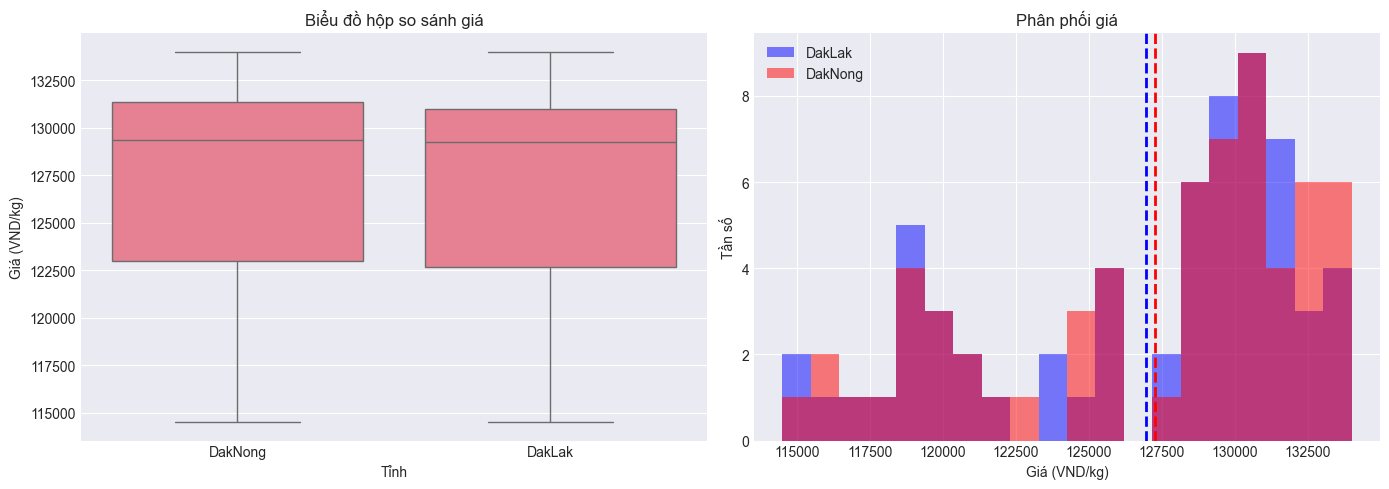

In [54]:
# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
df_compare = df_prices[df_prices['region'].isin(['DakLak', 'DakNong'])]
sns.boxplot(data=df_compare, x='region', y='price_vnd_per_kg', ax=axes[0])
axes[0].set_title('Biểu đồ hộp so sánh giá', fontsize=12)
axes[0].set_ylabel('Giá (VND/kg)')
axes[0].set_xlabel('Tỉnh')

# Histogram
axes[1].hist(daklak_price, bins=20, alpha=0.5, label='DakLak', color='blue')
axes[1].hist(daknong_price, bins=20, alpha=0.5, label='DakNong', color='red')
axes[1].axvline(mean_daklak, color='blue', linestyle='--', linewidth=2)
axes[1].axvline(mean_daknong, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Phân phối giá', fontsize=12)
axes[1].set_xlabel('Giá (VND/kg)')
axes[1].set_ylabel('Tần số')
axes[1].legend()

plt.tight_layout()
plt.show()

In [55]:
# So sánh giá: DakLak vs GiaLai
gialai_price = df_prices[df_prices['region'] == 'GiaLai']['price_vnd_per_kg']

mean_gialai = gialai_price.mean()
std_gialai = gialai_price.std()

print("=" * 60)
print("SO SÁNH GIÁ: DakLak vs GiaLai")
print("=" * 60)
print(f"\nDakLak:")
print(f"  Giá trung bình: {mean_daklak:,.0f} VND/kg")
print(f"  Số mẫu: {len(daklak_price)}")

print(f"\nGiaLai:")
print(f"  Giá trung bình: {mean_gialai:,.0f} VND/kg")
print(f"  Số mẫu: {len(gialai_price)}")

t_stat, p_val = ttest_ind(daklak_price, gialai_price)

print(f"\nKết quả T-Test:")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_val:.4f}")

if p_val < 0.05:
    print(f"\nKết luận: Có sự khác biệt có ý nghĩa")
else:
    print(f"\nKết luận: Không có sự khác biệt có ý nghĩa")

SO SÁNH GIÁ: DakLak vs GiaLai

DakLak:
  Giá trung bình: 126,954 VND/kg
  Số mẫu: 62

GiaLai:
  Giá trung bình: 126,913 VND/kg
  Số mẫu: 62

Kết quả T-Test:
  T-statistic: 0.0420
  P-value: 0.9666

Kết luận: Không có sự khác biệt có ý nghĩa


In [56]:
# So sánh giá: DakLak vs LamDong
lamdong_price = df_prices[df_prices['region'] == 'LamDong']['price_vnd_per_kg']

mean_lamdong = lamdong_price.mean()

print("=" * 60)
print("SO SÁNH GIÁ: DakLak vs LamDong")
print("=" * 60)
print(f"\nDakLak: {mean_daklak:,.0f} VND/kg")
print(f"LamDong: {mean_lamdong:,.0f} VND/kg")

t_stat, p_val = ttest_ind(daklak_price, lamdong_price)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print(f"Kết luận: Có sự khác biệt có ý nghĩa")
else:
    print(f"Kết luận: Không có sự khác biệt có ý nghĩa")

SO SÁNH GIÁ: DakLak vs LamDong

DakLak: 126,954 VND/kg
LamDong: 126,069 VND/kg

T-statistic: 0.9116
P-value: 0.3638
Kết luận: Không có sự khác biệt có ý nghĩa


In [57]:
# So sánh giá: DakNong vs GiaLai
print("=" * 60)
print("SO SÁNH GIÁ: DakNong vs GiaLai")
print("=" * 60)
print(f"\nDakNong: {mean_daknong:,.0f} VND/kg")
print(f"GiaLai: {mean_gialai:,.0f} VND/kg")

t_stat, p_val = ttest_ind(daknong_price, gialai_price)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print(f"Kết luận: Có sự khác biệt có ý nghĩa")
else:
    print(f"Kết luận: Không có sự khác biệt có ý nghĩa")

SO SÁNH GIÁ: DakNong vs GiaLai

DakNong: 127,252 VND/kg
GiaLai: 126,913 VND/kg

T-statistic: 0.3404
P-value: 0.7342
Kết luận: Không có sự khác biệt có ý nghĩa


In [58]:
# So sánh giá: DakNong vs LamDong
print("=" * 60)
print("SO SÁNH GIÁ: DakNong vs LamDong")
print("=" * 60)
print(f"\nDakNong: {mean_daknong:,.0f} VND/kg")
print(f"LamDong: {mean_lamdong:,.0f} VND/kg")

t_stat, p_val = ttest_ind(daknong_price, lamdong_price)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print(f"Kết luận: Có sự khác biệt có ý nghĩa")
else:
    print(f"Kết luận: Không có sự khác biệt có ý nghĩa")

SO SÁNH GIÁ: DakNong vs LamDong

DakNong: 127,252 VND/kg
LamDong: 126,069 VND/kg

T-statistic: 1.2060
P-value: 0.2301
Kết luận: Không có sự khác biệt có ý nghĩa


In [59]:
# So sánh giá: GiaLai vs LamDong
print("=" * 60)
print("SO SÁNH GIÁ: GiaLai vs LamDong")
print("=" * 60)
print(f"\nGiaLai: {mean_gialai:,.0f} VND/kg")
print(f"LamDong: {mean_lamdong:,.0f} VND/kg")

t_stat, p_val = ttest_ind(gialai_price, lamdong_price)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print(f"Kết luận: Có sự khác biệt có ý nghĩa")
else:
    print(f"Kết luận: Không có sự khác biệt có ý nghĩa")

SO SÁNH GIÁ: GiaLai vs LamDong

GiaLai: 126,913 VND/kg
LamDong: 126,069 VND/kg

T-statistic: 0.8654
P-value: 0.3885
Kết luận: Không có sự khác biệt có ý nghĩa


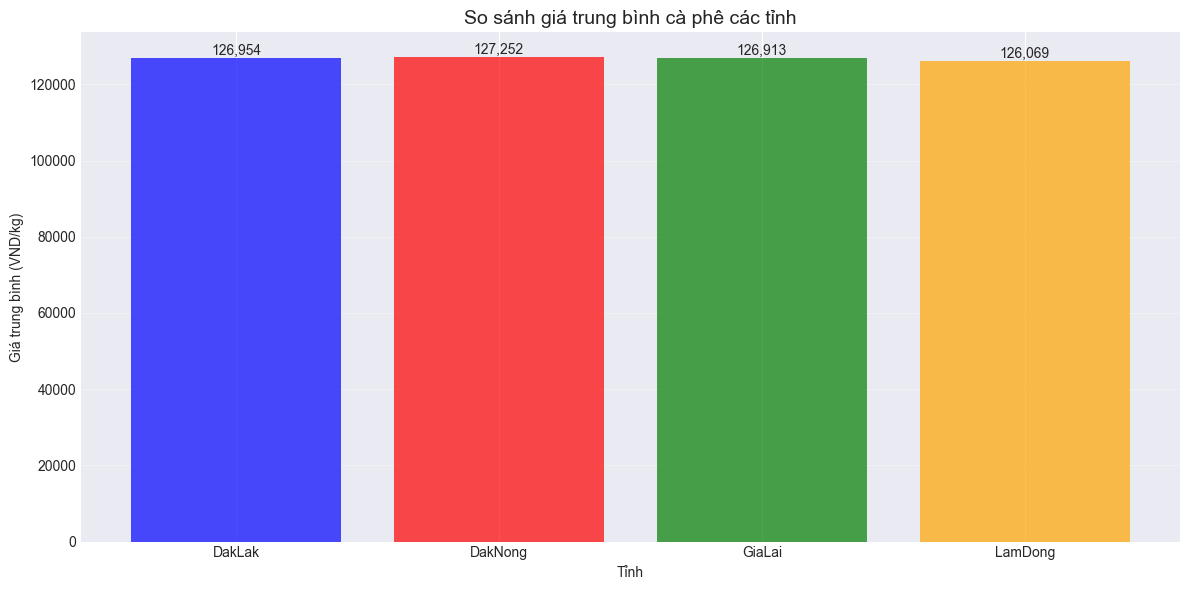

In [60]:
# Vẽ biểu đồ tổng hợp so sánh giá 4 tỉnh
fig, ax = plt.subplots(figsize=(12, 6))

provinces = ['DakLak', 'DakNong', 'GiaLai', 'LamDong']
means = [mean_daklak, mean_daknong, mean_gialai, mean_lamdong]
colors = ['blue', 'red', 'green', 'orange']

bars = ax.bar(provinces, means, color=colors, alpha=0.7)
ax.set_title('So sánh giá trung bình cà phê các tỉnh', fontsize=14)
ax.set_ylabel('Giá trung bình (VND/kg)')
ax.set_xlabel('Tỉnh')
ax.grid(axis='y', alpha=0.3)

# Thêm giá trị lên cột
for bar, mean in zip(bars, means):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:,.0f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 2. So sánh sản lượng giữa các tỉnh

In [61]:
# Lấy dữ liệu sản lượng
query_production = """
SELECT province, year, output_tons, area_thousand_ha
FROM production_by_province
WHERE year >= 2010 AND output_tons IS NOT NULL
ORDER BY year DESC
"""

df_production = pd.read_sql(query_production, engine)
print(f"Đã tải {len(df_production)} dòng dữ liệu sản lượng")
print(f"Các tỉnh: {df_production['province'].unique()}")
df_production.head()

Đã tải 70 dòng dữ liệu sản lượng
Các tỉnh: ['KonTum' 'GiaLai' 'DakNong' 'LamDong' 'DakLak']


,province,year,output_tons,area_thousand_ha
0,KonTum,2023,160558.92,58.95
1,GiaLai,2023,372522.58,136.77
2,DakNong,2023,286569.01,105.21
3,LamDong,2023,239261.31,87.84
4,DakLak,2023,902982.53,331.52


In [62]:
# So sánh sản lượng: DakLak vs DakNong
daklak_prod = df_production[df_production['province'] == 'DakLak']['output_tons']
daknong_prod = df_production[df_production['province'] == 'DakNong']['output_tons']

mean_daklak_prod = daklak_prod.mean()
mean_daknong_prod = daknong_prod.mean()

print("=" * 60)
print("SO SÁNH SẢN LƯỢNG: DakLak vs DakNong")
print("=" * 60)
print(f"\nDakLak:")
print(f"  Sản lượng TB: {mean_daklak_prod:,.0f} tấn")
print(f"  Số mẫu: {len(daklak_prod)}")

print(f"\nDakNong:")
print(f"  Sản lượng TB: {mean_daknong_prod:,.0f} tấn")
print(f"  Số mẫu: {len(daknong_prod)}")

t_stat, p_val = ttest_ind(daklak_prod, daknong_prod)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print(f"Kết luận: Có sự khác biệt có ý nghĩa")
else:
    print(f"Kết luận: Không có sự khác biệt có ý nghĩa")

SO SÁNH SẢN LƯỢNG: DakLak vs DakNong

DakLak:
  Sản lượng TB: 695,962 tấn
  Số mẫu: 14

DakNong:
  Sản lượng TB: 231,872 tấn
  Số mẫu: 14

T-statistic: 13.5012
P-value: 0.0000
Kết luận: Có sự khác biệt có ý nghĩa


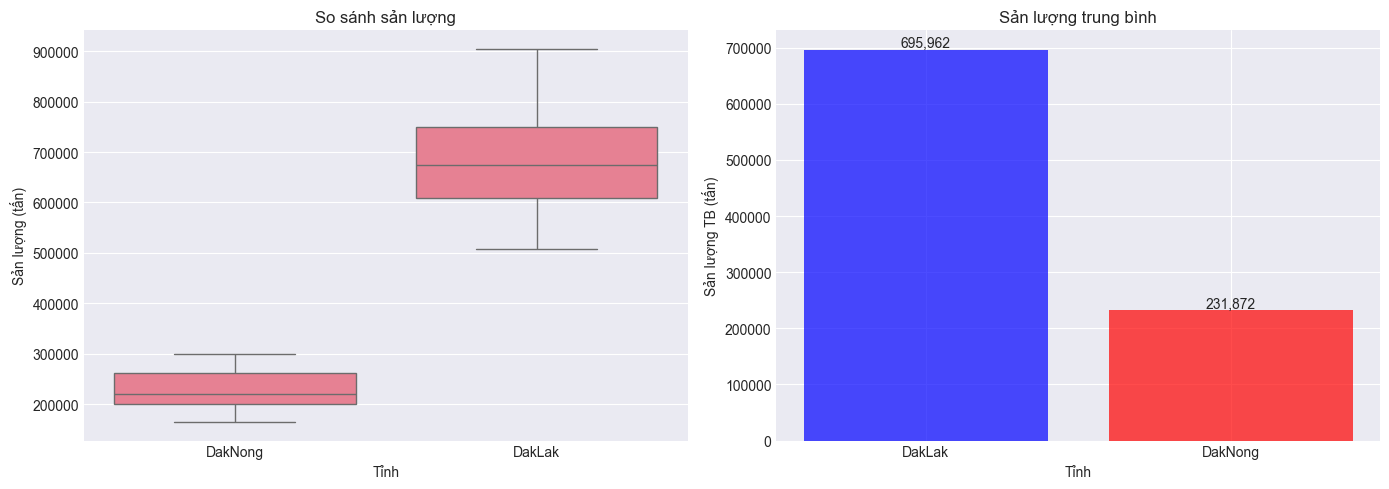

In [63]:
# Vẽ biểu đồ so sánh sản lượng
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
df_prod_compare = df_production[df_production['province'].isin(['DakLak', 'DakNong'])]
sns.boxplot(data=df_prod_compare, x='province', y='output_tons', ax=axes[0])
axes[0].set_title('So sánh sản lượng', fontsize=12)
axes[0].set_ylabel('Sản lượng (tấn)')
axes[0].set_xlabel('Tỉnh')

# Bar chart
provinces = ['DakLak', 'DakNong']
means = [mean_daklak_prod, mean_daknong_prod]
axes[1].bar(provinces, means, color=['blue', 'red'], alpha=0.7)
axes[1].set_title('Sản lượng trung bình', fontsize=12)
axes[1].set_ylabel('Sản lượng TB (tấn)')
axes[1].set_xlabel('Tỉnh')

for i, (prov, mean) in enumerate(zip(provinces, means)):
    axes[1].text(i, mean, f'{mean:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [64]:
# So sánh sản lượng các tỉnh còn lại
gialai_prod = df_production[df_production['province'] == 'GiaLai']['output_tons']
lamdong_prod = df_production[df_production['province'] == 'LamDong']['output_tons']

print("So sánh sản lượng các cặp tỉnh còn lại:\n")

# DakLak vs GiaLai
t_stat, p_val = ttest_ind(daklak_prod, gialai_prod)
print(f"DakLak vs GiaLai: T={t_stat:.4f}, p={p_val:.4f}")

# DakLak vs LamDong
t_stat, p_val = ttest_ind(daklak_prod, lamdong_prod)
print(f"DakLak vs LamDong: T={t_stat:.4f}, p={p_val:.4f}")

# DakNong vs GiaLai
t_stat, p_val = ttest_ind(daknong_prod, gialai_prod)
print(f"DakNong vs GiaLai: T={t_stat:.4f}, p={p_val:.4f}")

# DakNong vs LamDong
t_stat, p_val = ttest_ind(daknong_prod, lamdong_prod)
print(f"DakNong vs LamDong: T={t_stat:.4f}, p={p_val:.4f}")

# GiaLai vs LamDong
t_stat, p_val = ttest_ind(gialai_prod, lamdong_prod)
print(f"GiaLai vs LamDong: T={t_stat:.4f}, p={p_val:.4f}")

So sánh sản lượng các cặp tỉnh còn lại:

DakLak vs GiaLai: T=11.0217, p=0.0000
DakLak vs LamDong: T=15.0802, p=0.0000
DakNong vs GiaLai: T=-4.2433, p=0.0002
DakNong vs LamDong: T=3.1652, p=0.0039
GiaLai vs LamDong: T=7.3153, p=0.0000


## 3. So sánh diện tích trồng giữa các tỉnh

In [65]:
# So sánh diện tích: DakLak vs DakNong
daklak_area = df_production[df_production['province'] == 'DakLak']['area_thousand_ha']
daknong_area = df_production[df_production['province'] == 'DakNong']['area_thousand_ha']

mean_daklak_area = daklak_area.mean()
mean_daknong_area = daknong_area.mean()

print("=" * 60)
print("SO SÁNH DIỆN TÍCH: DakLak vs DakNong")
print("=" * 60)
print(f"\nDakLak: {mean_daklak_area:,.2f} nghìn ha")
print(f"DakNong: {mean_daknong_area:,.2f} nghìn ha")

t_stat, p_val = ttest_ind(daklak_area, daknong_area)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print(f"Kết luận: Có sự khác biệt có ý nghĩa")
else:
    print(f"Kết luận: Không có sự khác biệt có ý nghĩa")

SO SÁNH DIỆN TÍCH: DakLak vs DakNong

DakLak: 295.61 nghìn ha
DakNong: 98.49 nghìn ha

T-statistic: 32.3421
P-value: 0.0000
Kết luận: Có sự khác biệt có ý nghĩa


In [66]:
# So sánh diện tích các tỉnh còn lại
gialai_area = df_production[df_production['province'] == 'GiaLai']['area_thousand_ha']
lamdong_area = df_production[df_production['province'] == 'LamDong']['area_thousand_ha']

print("So sánh diện tích các cặp tỉnh:\n")

provinces_list = ['DakLak', 'DakNong', 'GiaLai', 'LamDong']
areas_list = [daklak_area, daknong_area, gialai_area, lamdong_area]

# So sánh tất cả các cặp
for i in range(len(provinces_list)):
    for j in range(i+1, len(provinces_list)):
        t_stat, p_val = ttest_ind(areas_list[i], areas_list[j])
        sig = "Có ý nghĩa" if p_val < 0.05 else "Không có ý nghĩa"
        print(f"{provinces_list[i]} vs {provinces_list[j]}: p={p_val:.4f} ({sig})")

So sánh diện tích các cặp tỉnh:

DakLak vs DakNong: p=0.0000 (Có ý nghĩa)
DakLak vs GiaLai: p=0.0000 (Có ý nghĩa)
DakLak vs LamDong: p=0.0000 (Có ý nghĩa)
DakNong vs GiaLai: p=0.0000 (Có ý nghĩa)
DakNong vs LamDong: p=0.0000 (Có ý nghĩa)
GiaLai vs LamDong: p=0.0000 (Có ý nghĩa)


## 4. So sánh năng suất giữa các tỉnh

In [67]:
# So sánh năng suất: DakLak vs DakNong
# Tính năng suất = output_tons / area_thousand_ha
df_production['yield_tons_per_ha'] = df_production['output_tons'] / (df_production['area_thousand_ha'] * 1000)

daklak_yield = df_production[df_production['province'] == 'DakLak']['yield_tons_per_ha']
daknong_yield = df_production[df_production['province'] == 'DakNong']['yield_tons_per_ha']

mean_daklak_yield = daklak_yield.mean()
mean_daknong_yield = daknong_yield.mean()

print("=" * 60)
print("SO SÁNH NĂNG SUẤT: DakLak vs DakNong")
print("=" * 60)
print(f"\nDakLak: {mean_daklak_yield:.2f} tấn/ha")
print(f"DakNong: {mean_daknong_yield:.2f} tấn/ha")

t_stat, p_val = ttest_ind(daklak_yield, daknong_yield)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print(f"Kết luận: Có sự khác biệt có ý nghĩa")
else:
    print(f"Kết luận: Không có sự khác biệt có ý nghĩa")

SO SÁNH NĂNG SUẤT: DakLak vs DakNong

DakLak: 2.34 tấn/ha
DakNong: 2.34 tấn/ha

T-statistic: -0.0003
P-value: 0.9998
Kết luận: Không có sự khác biệt có ý nghĩa


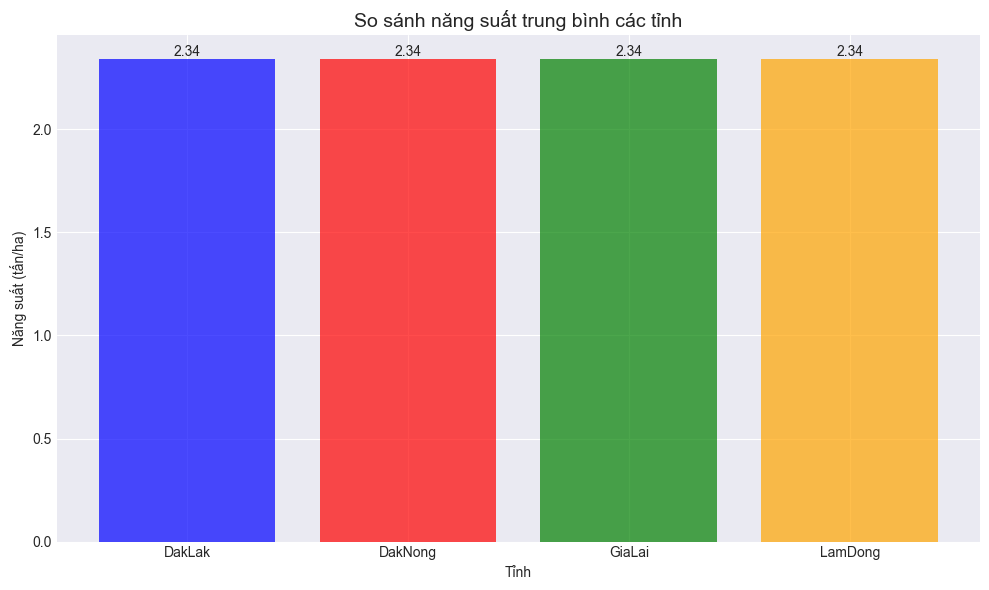

In [68]:
# Vẽ biểu đồ năng suất
gialai_yield = df_production[df_production['province'] == 'GiaLai']['yield_tons_per_ha']
lamdong_yield = df_production[df_production['province'] == 'LamDong']['yield_tons_per_ha']

fig, ax = plt.subplots(figsize=(10, 6))

provinces = ['DakLak', 'DakNong', 'GiaLai', 'LamDong']
yields = [
    daklak_yield.mean(),
    daknong_yield.mean(),
    gialai_yield.mean(),
    lamdong_yield.mean()
]

bars = ax.bar(provinces, yields, color=['blue', 'red', 'green', 'orange'], alpha=0.7)
ax.set_title('So sánh năng suất trung bình các tỉnh', fontsize=14)
ax.set_ylabel('Năng suất (tấn/ha)')
ax.set_xlabel('Tỉnh')

for bar, y in zip(bars, yields):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{y:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 5. So sánh thời tiết giữa các tỉnh

In [69]:
# Lấy dữ liệu thời tiết
query_weather = """
SELECT province, year, month,
       temperature_mean, precipitation_sum, humidity_mean
FROM weather_data_monthly
WHERE year >= 2010
ORDER BY year DESC, month DESC
"""

df_weather = pd.read_sql(query_weather, engine)
print(f"Đã tải {len(df_weather)} dòng dữ liệu thời tiết")
df_weather.head()

Đã tải 950 dòng dữ liệu thời tiết


,province,year,month,temperature_mean,precipitation_sum,humidity_mean
0,DakLak,2025,10,24.29,274.0,85.10
1,GiaLai,2025,10,22.58,217.0,85.81
2,DakNong,2025,10,23.27,217.1,88.48
3,KonTum,2025,10,23.73,215.9,84.42
4,LamDong,2025,10,21.65,240.7,90.23


In [70]:
# So sánh nhiệt độ: DakLak vs DakNong
daklak_temp = df_weather[df_weather['province'] == 'DakLak']['temperature_mean']
daknong_temp = df_weather[df_weather['province'] == 'DakNong']['temperature_mean']

mean_daklak_temp = daklak_temp.mean()
mean_daknong_temp = daknong_temp.mean()

print("=" * 60)
print("SO SÁNH NHIỆT ĐỘ: DakLak vs DakNong")
print("=" * 60)
print(f"\nDakLak: {mean_daklak_temp:.2f}°C")
print(f"DakNong: {mean_daknong_temp:.2f}°C")

t_stat, p_val = ttest_ind(daklak_temp, daknong_temp)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print(f"Kết luận: Có sự khác biệt có ý nghĩa")
else:
    print(f"Kết luận: Không có sự khác biệt có ý nghĩa")

SO SÁNH NHIỆT ĐỘ: DakLak vs DakNong

DakLak: 24.49°C
DakNong: 23.38°C

T-statistic: 7.2262
P-value: 0.0000
Kết luận: Có sự khác biệt có ý nghĩa


In [71]:
# So sánh lượng mưa: DakLak vs DakNong
daklak_rain = df_weather[df_weather['province'] == 'DakLak']['precipitation_sum']
daknong_rain = df_weather[df_weather['province'] == 'DakNong']['precipitation_sum']

mean_daklak_rain = daklak_rain.mean()
mean_daknong_rain = daknong_rain.mean()

print("=" * 60)
print("SO SÁNH LƯỢNG MƯA: DakLak vs DakNong")
print("=" * 60)
print(f"\nDakLak: {mean_daklak_rain:.2f} mm")
print(f"DakNong: {mean_daknong_rain:.2f} mm")

t_stat, p_val = ttest_ind(daklak_rain, daknong_rain)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print(f"Kết luận: Có sự khác biệt có ý nghĩa")
else:
    print(f"Kết luận: Không có sự khác biệt có ý nghĩa")

SO SÁNH LƯỢNG MƯA: DakLak vs DakNong

DakLak: 139.15 mm
DakNong: 174.81 mm

T-statistic: -2.5268
P-value: 0.0119
Kết luận: Có sự khác biệt có ý nghĩa


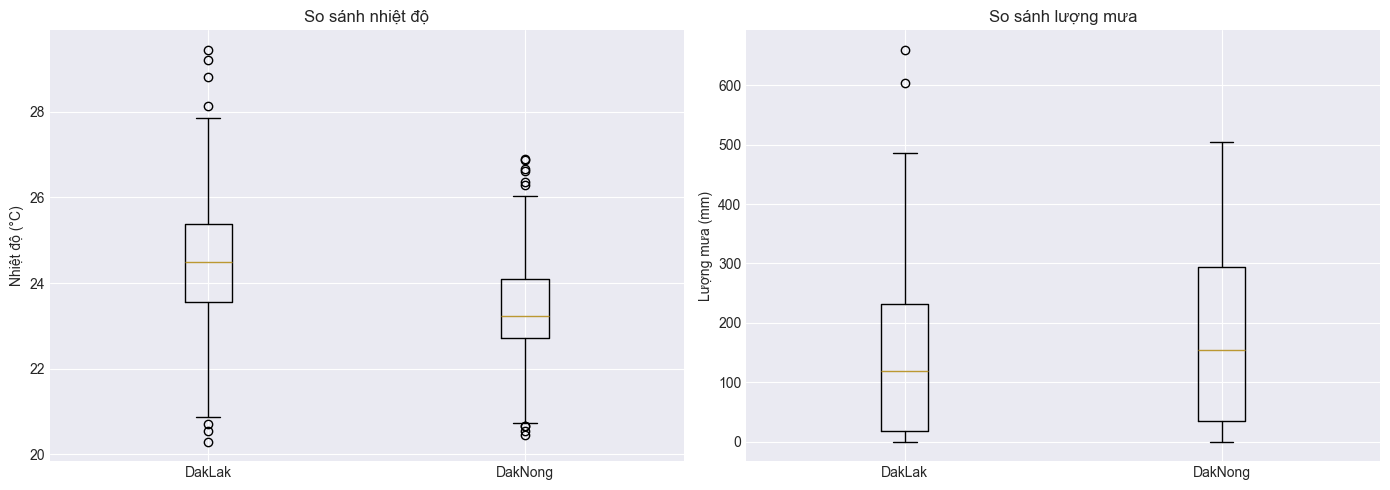

In [72]:
# Vẽ biểu đồ so sánh thời tiết
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# So sánh nhiệt độ
temp_data = [daklak_temp, daknong_temp]
axes[0].boxplot(temp_data, labels=['DakLak', 'DakNong'])
axes[0].set_title('So sánh nhiệt độ', fontsize=12)
axes[0].set_ylabel('Nhiệt độ (°C)')

# So sánh lượng mưa
rain_data = [daklak_rain, daknong_rain]
axes[1].boxplot(rain_data, labels=['DakLak', 'DakNong'])
axes[1].set_title('So sánh lượng mưa', fontsize=12)
axes[1].set_ylabel('Lượng mưa (mm)')

plt.tight_layout()
plt.show()

In [73]:
# So sánh độ ẩm: DakLak vs DakNong
daklak_humid = df_weather[df_weather['province'] == 'DakLak']['humidity_mean']
daknong_humid = df_weather[df_weather['province'] == 'DakNong']['humidity_mean']

print("=" * 60)
print("SO SÁNH ĐỘ ẨM: DakLak vs DakNong")
print("=" * 60)
print(f"\nDakLak: {daklak_humid.mean():.2f}%")
print(f"DakNong: {daknong_humid.mean():.2f}%")

t_stat, p_val = ttest_ind(daklak_humid, daknong_humid)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print(f"Kết luận: Có sự khác biệt có ý nghĩa")
else:
    print(f"Kết luận: Không có sự khác biệt có ý nghĩa")

SO SÁNH ĐỘ ẨM: DakLak vs DakNong

DakLak: 76.63%
DakNong: 81.87%

T-statistic: -5.6212
P-value: 0.0000
Kết luận: Có sự khác biệt có ý nghĩa


## 6. Tổng kết

In [74]:
print("=" * 70)
print("TỔNG KẾT PHÂN TÍCH T-TEST")
print("=" * 70)
print("\nĐã thực hiện kiểm định T-Test cho:")
print("\n1. So sánh giá cà phê giữa các tỉnh (6 cặp)")
print("2. So sánh sản lượng giữa các tỉnh (6 cặp)")
print("3. So sánh diện tích trồng giữa các tỉnh (6 cặp)")
print("4. So sánh năng suất giữa các tỉnh (6 cặp)")
print("5. So sánh nhiệt độ giữa các tỉnh")
print("6. So sánh lượng mưa giữa các tỉnh")
print("7. So sánh độ ẩm giữa các tỉnh")
print("\nTất cả các kiểm định đều sử dụng mức ý nghĩa α = 0.05")
print("Nếu p-value < 0.05: Có sự khác biệt có ý nghĩa thống kê")
print("Nếu p-value >= 0.05: Không có sự khác biệt có ý nghĩa thống kê")
print("=" * 70)

TỔNG KẾT PHÂN TÍCH T-TEST

Đã thực hiện kiểm định T-Test cho:

1. So sánh giá cà phê giữa các tỉnh (6 cặp)
2. So sánh sản lượng giữa các tỉnh (6 cặp)
3. So sánh diện tích trồng giữa các tỉnh (6 cặp)
4. So sánh năng suất giữa các tỉnh (6 cặp)
5. So sánh nhiệt độ giữa các tỉnh
6. So sánh lượng mưa giữa các tỉnh
7. So sánh độ ẩm giữa các tỉnh

Tất cả các kiểm định đều sử dụng mức ý nghĩa α = 0.05
Nếu p-value < 0.05: Có sự khác biệt có ý nghĩa thống kê
Nếu p-value >= 0.05: Không có sự khác biệt có ý nghĩa thống kê
